In [399]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import import_ipynb
from sklearn.model_selection import GroupShuffleSplit
import numpy_indexed as npi
from scipy import stats
import qgrid
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns

### Leer dataset

In [412]:
PATHDATA_MFFC_AVG = '../../../data/audios_MFCC_average_5000_tracks.csv'
df = pd.read_csv(PATHDATA_MFFC_AVG, header = None)
data = df.values #Convertimos en un  numpy array

In [413]:
X = data[:,0:-3]
Y = data[:,-2]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-1]
tracks = data[:,-3:-2]

Tamaño dataSet (53867, 20)




### Número de clases

In [414]:
n_classes=len(np.unique(Y))
print('Número de clases:', n_classes)

Número de clases: 5


### Número de hablantes

In [415]:
n_groups = len(np.unique(groups))
print('Número de hablantes diferentes', n_groups)

Número de hablantes diferentes 668


### Número de Audios

In [416]:
n_tracks = len(np.unique(tracks))
print('Número de audios diferentes',n_tracks)

Número de audios diferentes 5000


## Dividir el dataset (train/test) 0.8/0.2

In [417]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
gss.get_n_splits()
for train_index, test_index in gss.split(X, Y, groups=groups):
    X_train_original, X_test_original = X[train_index], X[test_index]
    #print(X_train, X_test)
    Y_train__original, Y_test_original = Y[train_index], Y[test_index]
    #print(y_train, y_test)
    groups_original = groups[train_index]
    groups_test_original=groups[test_index]
    tracks_train_original = tracks[train_index]
    tracks_test_original = tracks[test_index]   

### Info TRAIN

In [418]:
print('X',X_train_original.shape)
print('Groups',len(np.unique(groups_original)))
print('Tracks',len(np.unique(tracks_train_original)))

X (44327, 20)
Groups 534
Tracks 4111


### Info TEST

In [419]:
print('X',X_test_original.shape)
print('Groups',len(np.unique(groups_test_original)))
print('Tracks',len(np.unique(tracks_test_original)))

X (9540, 20)
Groups 134
Tracks 889


In [420]:
FOLDS = 10
TRAIN_SIZE = 0.8

# GaussianMixture (GMM) 

## 1. Mejor modelo

Usamos X_train_original y Y_train__original para seleccionar la mejor combinación de parametros y posteriormente validar dichos res]ultados con el conjunto X_test__original y Y_test__original.

<b>Nota:</b> el conjunto X_train_original se divide en dos conjuntos train y dev a una proporción de 80 a 20.

In [421]:
def GMMClassifierTrain(X,Y,M,tipo):    
    #X: Matriz con las características
    #Y: Matriz con las clases
    #M: Número de componentes
    #tipo: Tipo de matriz de covarianza
    nClases = np.unique(Y)
    
    GMMs = [] # Vector que tiene los modelos GMM entrendao
    
    for c in nClases:
        gmm = GaussianMixture(M,tipo)#Configurar el modelo                
        XY=np.column_stack((X,Y))
        Xc =np.where(XY[:,-1]==c) # Seleccionamos la matrix de la clase a entrenar
        Xc=X[Xc]        
        GMMs.append(gmm.fit(Xc)) #GMMs Debe retornar un objeto que contenga todos los modelos entrenados        
        
    return GMMs

In [422]:
def GMMClassfierVal(GMMs,Xtest,tracks_test):
    nGmm = len(GMMs) #Numero de modelos que existen
    nSamples = len(Xtest) #Numero de muestras a clasificar
    """Creamos una matriz de tamaño nSamples,nGmm en donde
    cada valor de la columna representa la probabilidad de que esta muestra pertenezca a dicha clase
    la pocision del mayor valor de la columna es la clase a la que se predice pertenecera
    """
    mProbabilities = np.zeros((nSamples,nGmm))
    for i in range(nGmm):
        mProbabilities[:,i]=GMMs[i].score_samples(Xtest)
    Yest = np.argmax(mProbabilities,axis=1)    
    
    #Creamos un matriz con la primera fila las predicciones y la otra el track      
    X_test_with_id_trak = np.column_stack((Yest,tracks_test))

    #Agrupamos por audio
    prediction_by_instances = npi.group_by(X_test_with_id_trak[:, -1]).split(X_test_with_id_trak[:, -2])
    
    
    #Sacamos la moda de prediccion
    predictions = []

    for v in range(len(prediction_by_instances)):
        decision = stats.mode(prediction_by_instances[v])[0]
        predictions.append(decision)
    
    return np.array(predictions) #Debe retornar un vector con las clases predichas para cada una de las muestras en Xtest, de acuerdo con los modelos almacenados en GMMs

In [423]:
def TRAIN(n_components,covariance_type,X_train,Y_train,tracks_train,train_size,folds,groups_train):
    gss = GroupShuffleSplit(n_splits=folds, train_size=.7)
    EficienciaTrain = np.zeros(folds)
    EficienciaVal = np.zeros(folds)
    j = 0
    GMMs = []
    for train_idx, test_idx in gss.split(X_train, Y_train, groups_train):
        
        X_train_fold =X_train[train_idx]
        Y_train_fold=Y_train[train_idx]
        X_test_fold=X_train[test_idx]
        Y_test_fold=Y_train[test_idx]
        
        tracks_train_fold=tracks_train[train_idx]
        tracks_test_fold=tracks_train[test_idx]
        
        #Entrenamiento
        GMMs = GMMClassifierTrain(X_train_fold,Y_train_fold,n_components,covariance_type)
        
         #Validación
        Ytrain_pred = GMMClassfierVal(GMMs,X_train_fold,tracks_train_fold)
        
        Ytest_pred = GMMClassfierVal(GMMs,X_test_fold,tracks_test_fold)
        
        
        #Metricas en entrenamiento
        
        #Hacer groupby por tracks
        Y_real_train = createGroups(Y_train_fold,tracks_train_fold)
        Y_real_test = createGroups(Y_test_fold,tracks_test_fold)
        
        """
        print('TRAIN')
        print('Predicted',Ytrain_pred )
        print('Real',Y_real_train)
        
        print('----------------')
        print('TEST')
        print('Predicted',Ytest_pred)
        print('Real',Y_real_test)
        
        """
                
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Y_real_train.ravel())
        EficienciaVal[j] = np.mean(Ytest_pred.ravel() == Y_real_test.ravel())
        j += 1
        
    eficiencia_Train=(np.mean(EficienciaTrain))
    intervalo_Train=(np.std(EficienciaTrain))
    eficiencia_Test=np.mean(EficienciaVal)
    intervalo_Test=np.std(EficienciaVal)
    #print('Eficiencia durante el entrenamiento = ' + str(eficiencia_Train) + '+-' + str(intervalo_Train))
    #print('Eficiencia durante la validación = ' + str(eficiencia_Test) + '+-' + str(intervalo_Test)) 
    #Se retorna el modelo del ultimo fold
    return GMMs,eficiencia_Train,intervalo_Train,eficiencia_Test,intervalo_Test

In [424]:
def createGroups(Y,tracks):
    Y_train_tracks = np.column_stack((Y,tracks))
    groups_by_tracks = npi.group_by(Y_train_tracks[:, -1]).split(Y_train_tracks[:, -2])
    modas = []

    for v in range(len(groups_by_tracks)):
        moda = stats.mode(groups_by_tracks[v])[0]
        modas.append(moda)
    return np.array(modas)

In [425]:
def changeName(name):
    covNameSklearn = ['full','tied','diag','spherical']
    covName = ['Completa','Atada','Diagonal','Esférica']
    return covNameSklearn[covName.index(name)]

In [ ]:
X_train=X_train_original
Y_train=Y_train__original
tracks_train=tracks_train_original
train_size=TRAIN_SIZE
folds=FOLDS
groups_train=groups_original


df_types = pd.DataFrame({
    'Matriz de covarianza' : pd.Series(['Completa','Completa','Completa','Completa','Completa','Completa','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Esférica','Esférica','Esférica','Esférica','Esférica','Esférica','Atada','Atada','Atada','Atada','Atada','Atada']),
    'Numero de componentes' : pd.Series([1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6])})

df_types["Eficiencia en train"] = ""
df_types["Intervalo de confianza train"] = ""
df_types["Eficiencia en test"] = ""
df_types["Intervalo de confianza test"] = ""

df_types.set_index(['Matriz de covarianza','Numero de componentes'], inplace=True)
cont = 0
for tipo,m in df_types.index:
    _,eficiencia_Train,intervalo_Train,eficiencia_Test,intervalo_Test=TRAIN(int(m),changeName(str(tipo)),X_train,Y_train,tracks_train,train_size,folds,groups_train)
    df_types["Eficiencia en train"][cont] = str(eficiencia_Train)
    df_types["Intervalo de confianza train"][cont] =str(intervalo_Train)
    df_types["Eficiencia en test"][cont]=str(eficiencia_Test)
    df_types["Intervalo de confianza test"][cont]=str(intervalo_Test)
    cont = cont +1
df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

/home/josearangos/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/josearangos/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/josearangos/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/josearangos/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check f

In [ ]:
qgrid_widget.get_changed_df()

El mejor modelo es: 

## 2. Evalución mejor modelo con el conjunto de test

In [374]:
n_components=4
covariance_type='full'
X_train=X_train_original
Y_train=Y_train__original
tracks_train=tracks_train_original
train_size=TRAIN_SIZE
folds=FOLDS
groups_train=groups_original

modelsGMM,_,_,_,_ = TRAIN(n_components,covariance_type,X_train,Y_train,tracks_train,train_size,folds,groups_train)

In [376]:
Ytest_pred= GMMClassfierVal(modelsGMM,X_test_original,tracks_test_original)

In [377]:
Y_real_test = createGroups(Y_test_original,tracks_test_original)

Accuracy:  0.0 


classification report :
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       2.0
         1.0       0.00      0.00      0.00       1.0
         3.0       0.00      0.00      0.00       2.0
         4.0       0.00      0.00      0.00       0.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/home/josearangos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


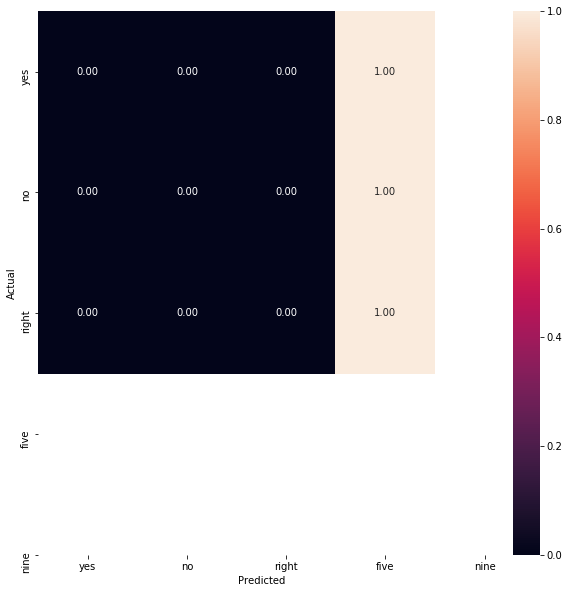

In [379]:
print('Accuracy: ', accuracy_score(Y_real_test, Ytest_pred), '\n')
report = classification_report(Y_real_test, Ytest_pred)
print("\nclassification report :\n",report )
# Matriz de confusión
clases =['yes','no','right','five','nine']
cm = confusion_matrix(Y_real_test, Ytest_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clases, yticklabels=clases)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
plt.show(block=False)

## Learning Curve

In [380]:
def learning_curve(n_components,covariance_type,folds, X,Y,groups,tracks, suptitle='', title='', xlabel='Training Set Size', ylabel='Acurracy'):
        """
        Parameters
        ----------
        suptitle : str
            Chart suptitle
        title: str
            Chart title
        xlabel: str
            Label for the X axis
        ylabel: str
            Label for the y axis
        Returns
        -------
        Plot of learning curves
        """

        # create lists to store train and validation scores
        train_score = []
        val_score = []
        std_train= []
        std_val=[]

        # create ten incremental training set sizes
        training_set_sizes = np.linspace(.1,.9,5).tolist()
        # for each one of those training set sizes

        for i in training_set_sizes:  
            
            modelsGMM, eficiencia_Train,intervalo_Train,eficiencia_Test,intervalo_Test=TRAIN(n_components,covariance_type,X,Y,tracks,i,folds,groups)
            
            
            # store the scores in their respective lists
            train_score.append(eficiencia_Train)
            val_score.append(eficiencia_Test)
            std_train.append(intervalo_Train)
            std_val.append(intervalo_Test)

        train_score =np.array(train_score)
        val_score =np.array(val_score)
        std_train =np.array(std_train)
        std_val =np.array(std_val)


        # plot learning curves
        fig, ax = plt.subplots(figsize=(14, 9))
        ax.plot(training_set_sizes, train_score, c='gold')
        ax.plot(training_set_sizes, val_score, c='steelblue')

        ax.fill_between(training_set_sizes,train_score+std_train,train_score-std_train,facecolor='gold',alpha=0.5)
        ax.fill_between(training_set_sizes,val_score+std_val,val_score-std_val,facecolor='steelblue',alpha=0.5)

        # format the chart to make it look nice
        fig.suptitle(suptitle, fontweight='bold', fontsize='20')
        ax.set_title(title, size=20)
        ax.set_xlabel(xlabel, size=16)
        ax.set_ylabel(ylabel, size=16)
        ax.legend(['Train set', 'Test set'], fontsize=16)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_ylim(0, 1)

        def percentages(x, pos):
            """The two args are the value and tick position"""
            if x < 1:
                return '{:1.0f}'.format(x*100)
            return '{:1.0f}%'.format(x*100)

        def numbers(x, pos):
            """The two args are the value and tick position"""
            if x >= 1000:
                return '{:1,.0f}'.format(x)
            return '{:1.0f}'.format(x)
        data = {'Train_Size':training_set_sizes, 'mean_train_Accuracy':train_score,'mean_test_Accuracy':val_score,'std_train_Accuracy':std_train,'std_test_Accuracy':std_val}
        df_split_params = pd.DataFrame(data)
        return df_split_params

,Train_Size,mean_train_Accuracy,mean_test_Accuracy,std_train_Accuracy,std_test_Accuracy
0,0.1,0.971872,0.106905,0.030758,0.119029
1,0.3,0.898420,0.106058,0.191329,0.058890
2,0.5,0.984991,0.123864,0.030030,0.059353
3,0.7,0.983426,0.115186,0.025808,0.077839
4,0.9,0.968789,0.091524,0.033729,0.121226


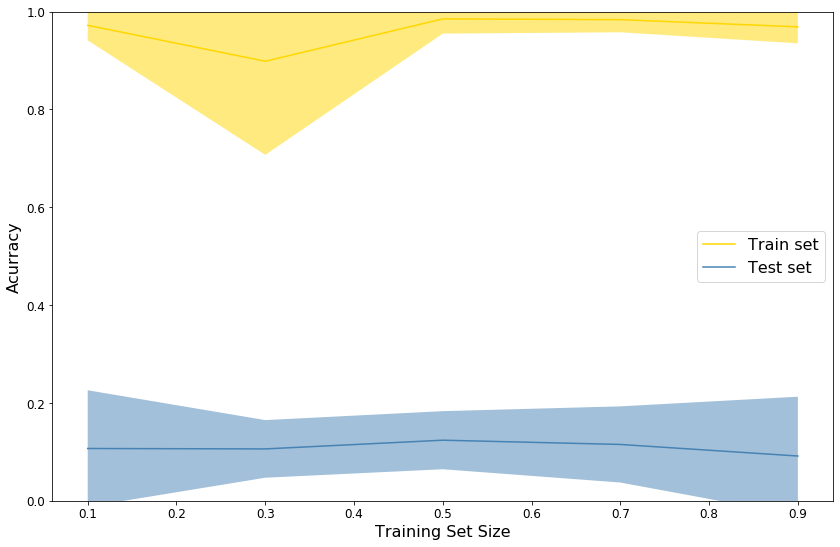

In [381]:

n_components=4
covariance_type='full'
folds=10
learning_curve(n_components,covariance_type,folds, X,Y,groups,tracks, suptitle='', title='', xlabel='Training Set Size', ylabel='Acurracy')